# Signals Analysis Data Processing

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
sns.set_context('talk')

# Preprocessing

In [2]:
workingDirectory = '/home/jtao/analysis/genomic_grammar_analysis/'
os.chdir(workingDirectory)

In [86]:
%%capture
!summarize_logs.py atac ./qc_atac ./tag_directories_atac/*/
!summarize_logs.py rna ./qc_chip ./tag_directories_chip/*/

In [3]:
summary_atac_frame = pd.read_csv('./qc_atac/mapping_stats.tsv', sep='\t')
summary_atac_frame['genome'] = 'mm10'
sample_names = summary_atac_frame['sample'].values
summary_atac_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_atac_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_atac_frame['treatment'] = [x.split('_')[3] for x in sample_names]



## C57Bl6 ATAC-seq

### Mapping Quality Control

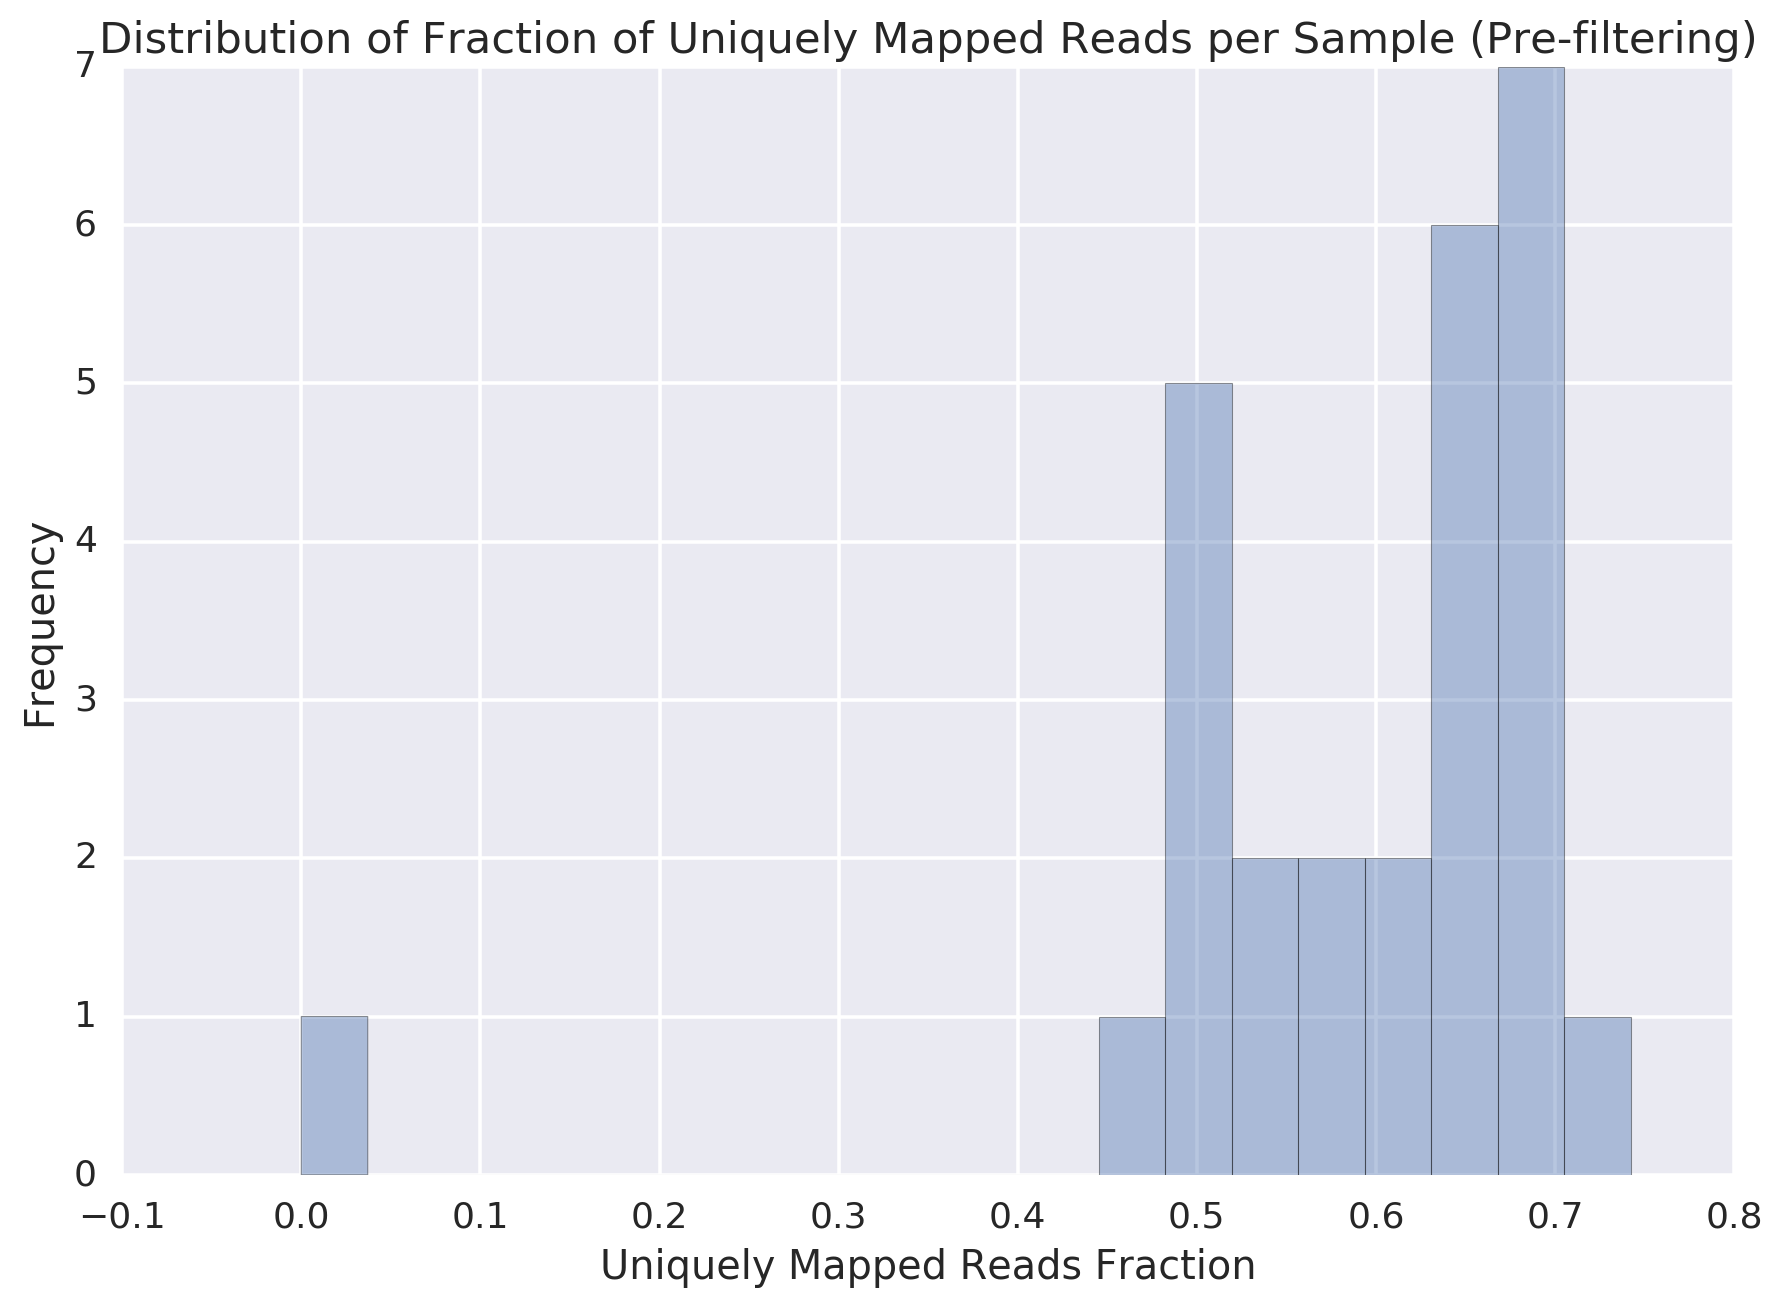

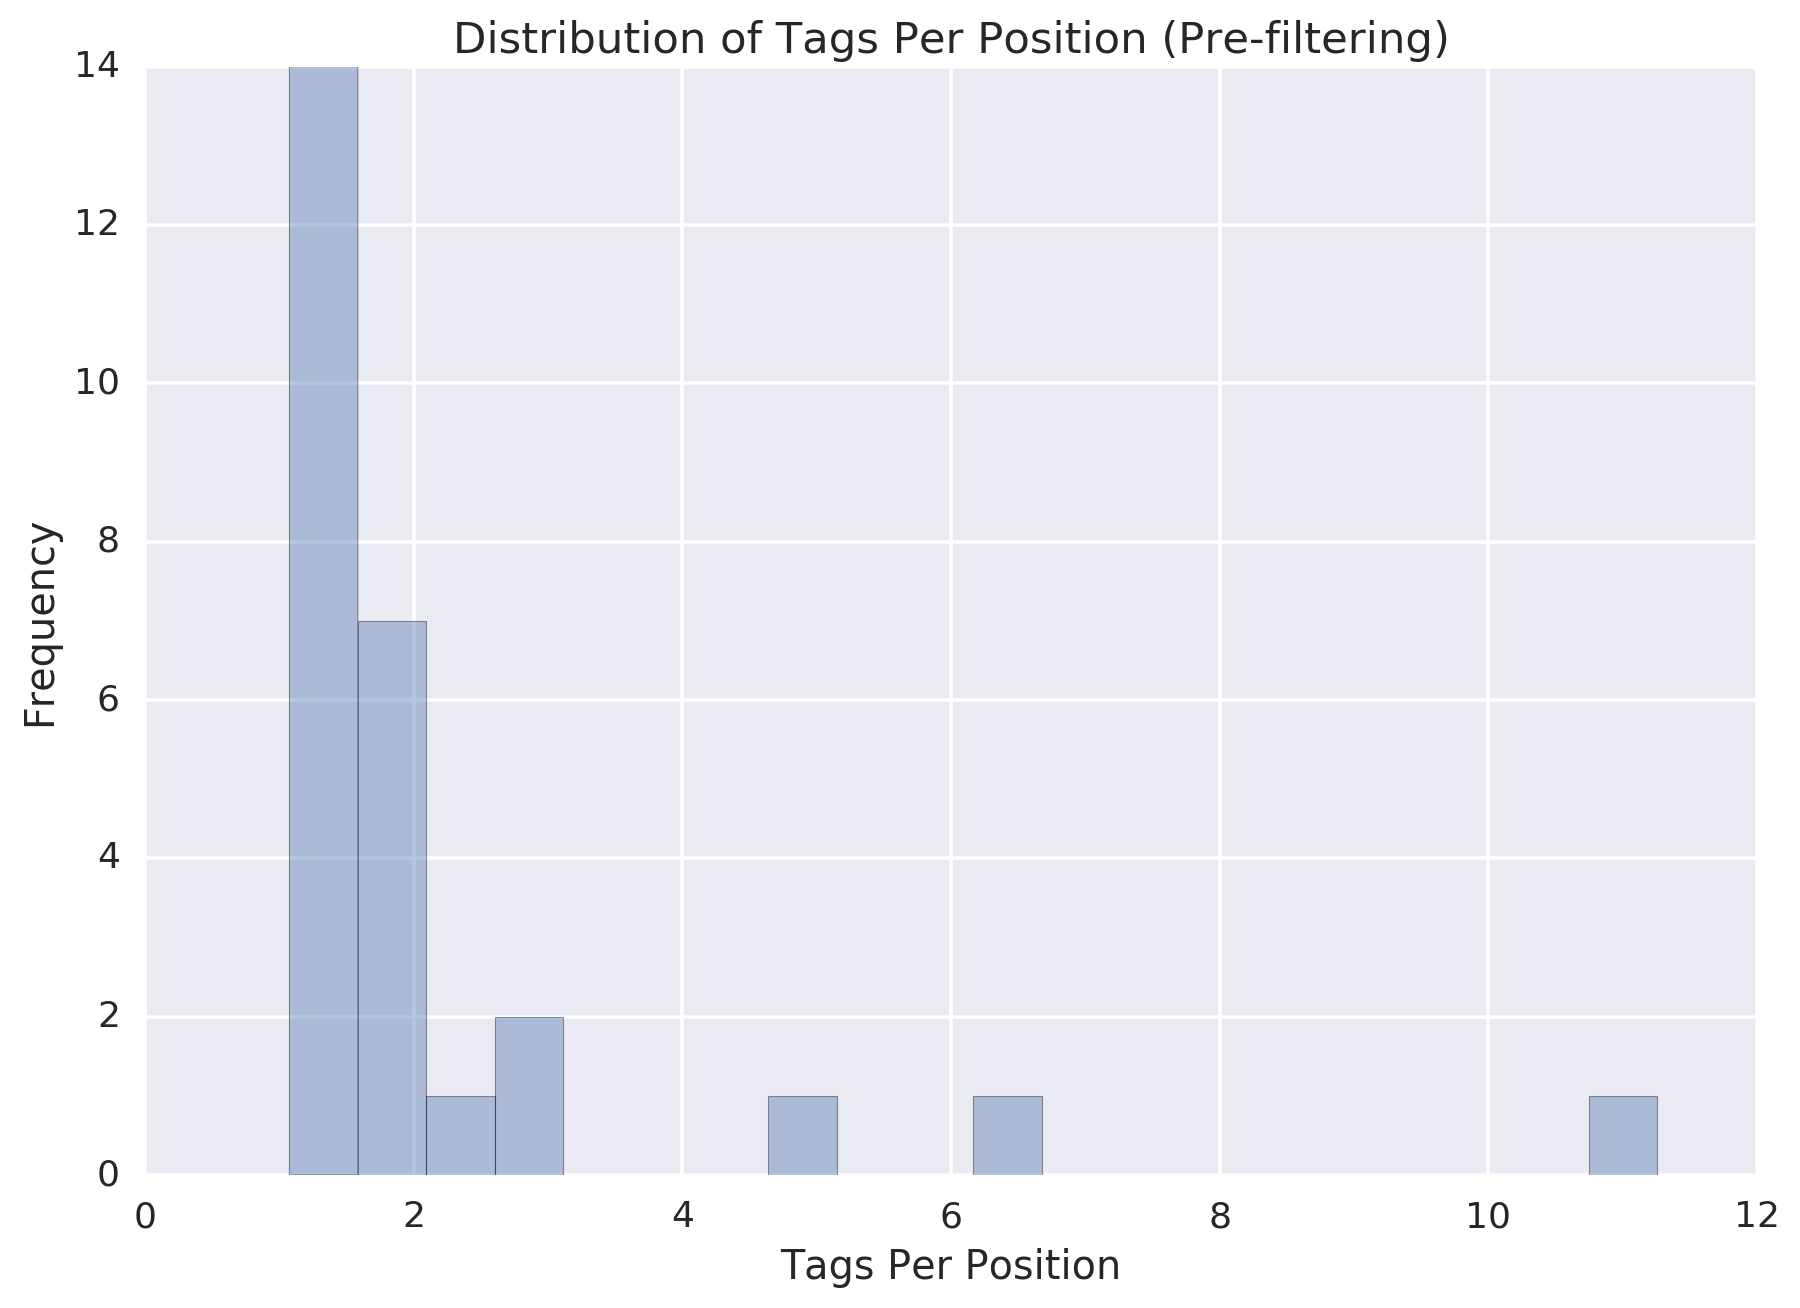

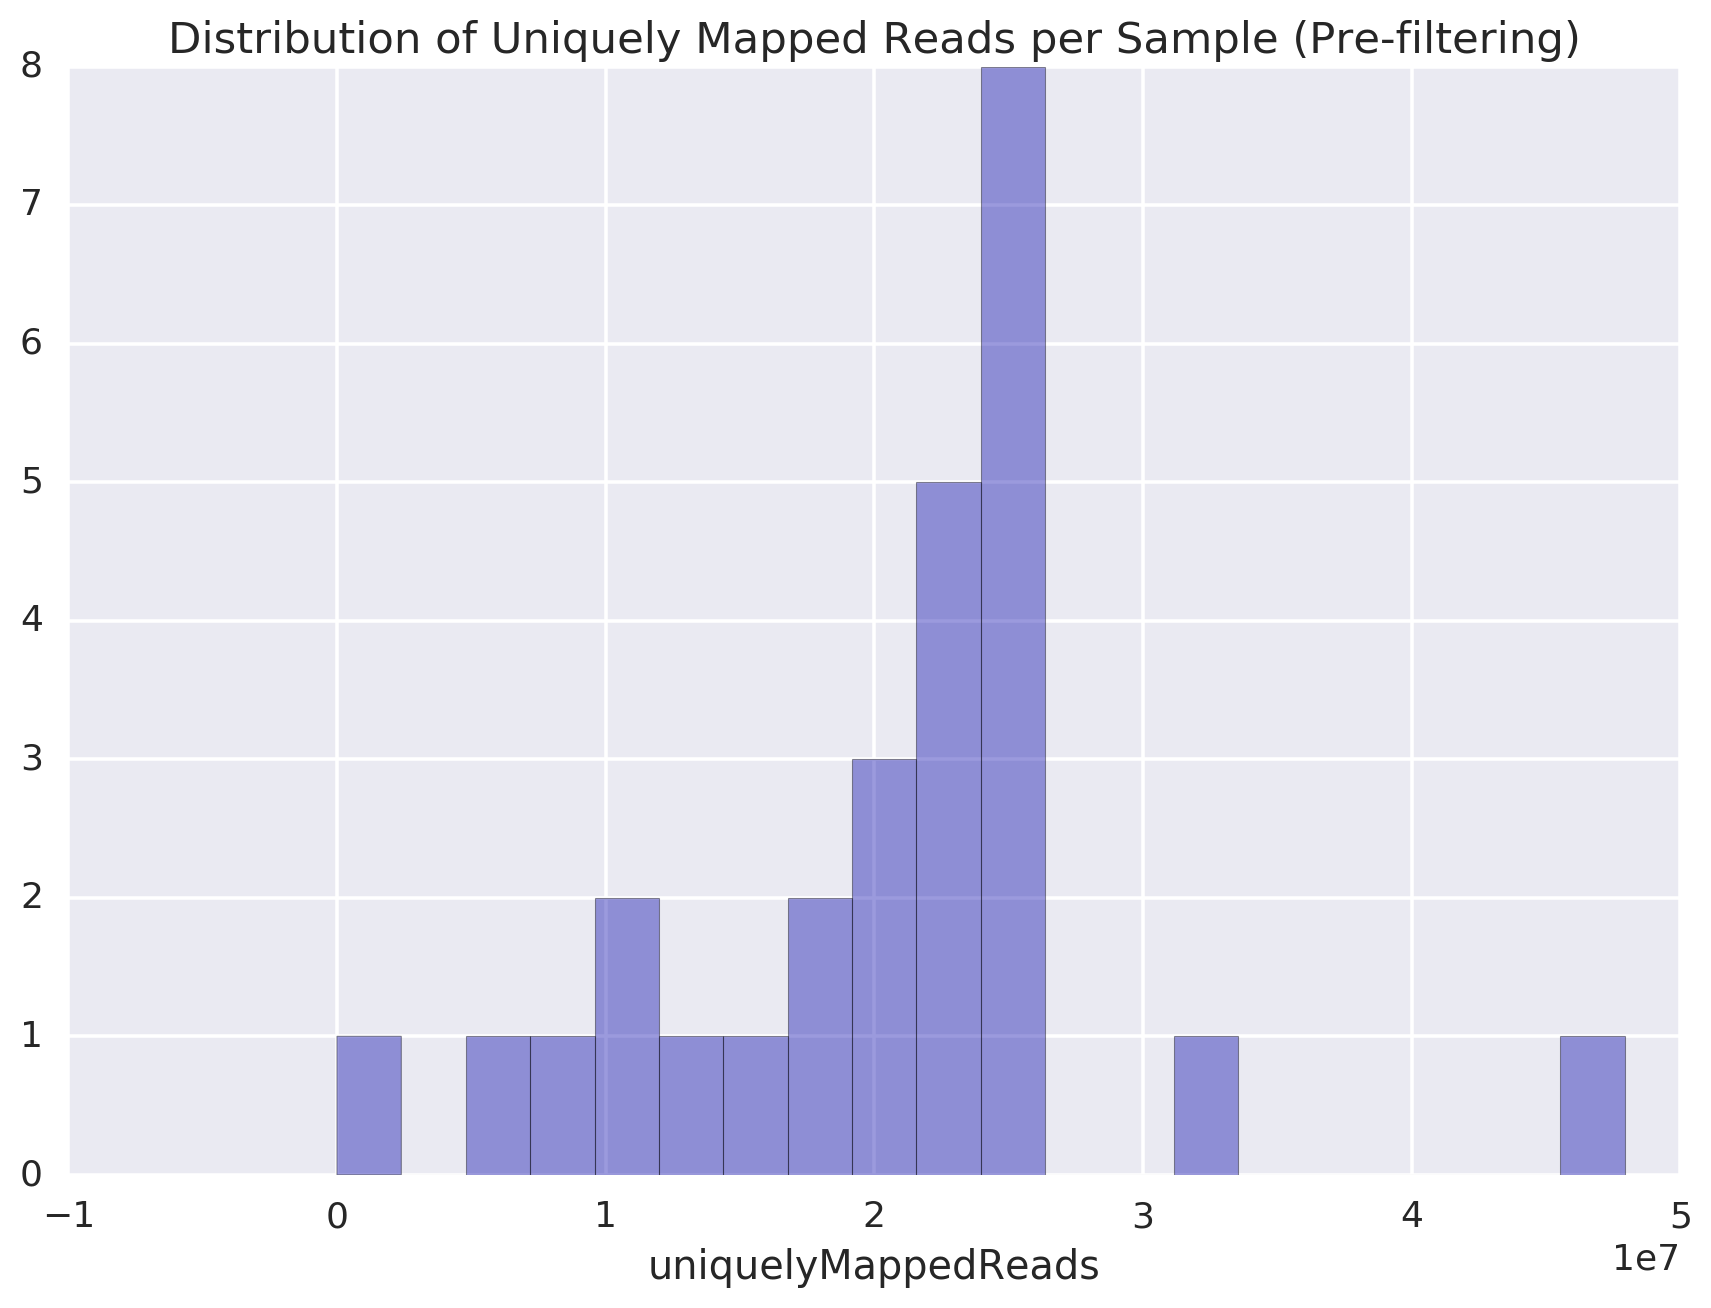

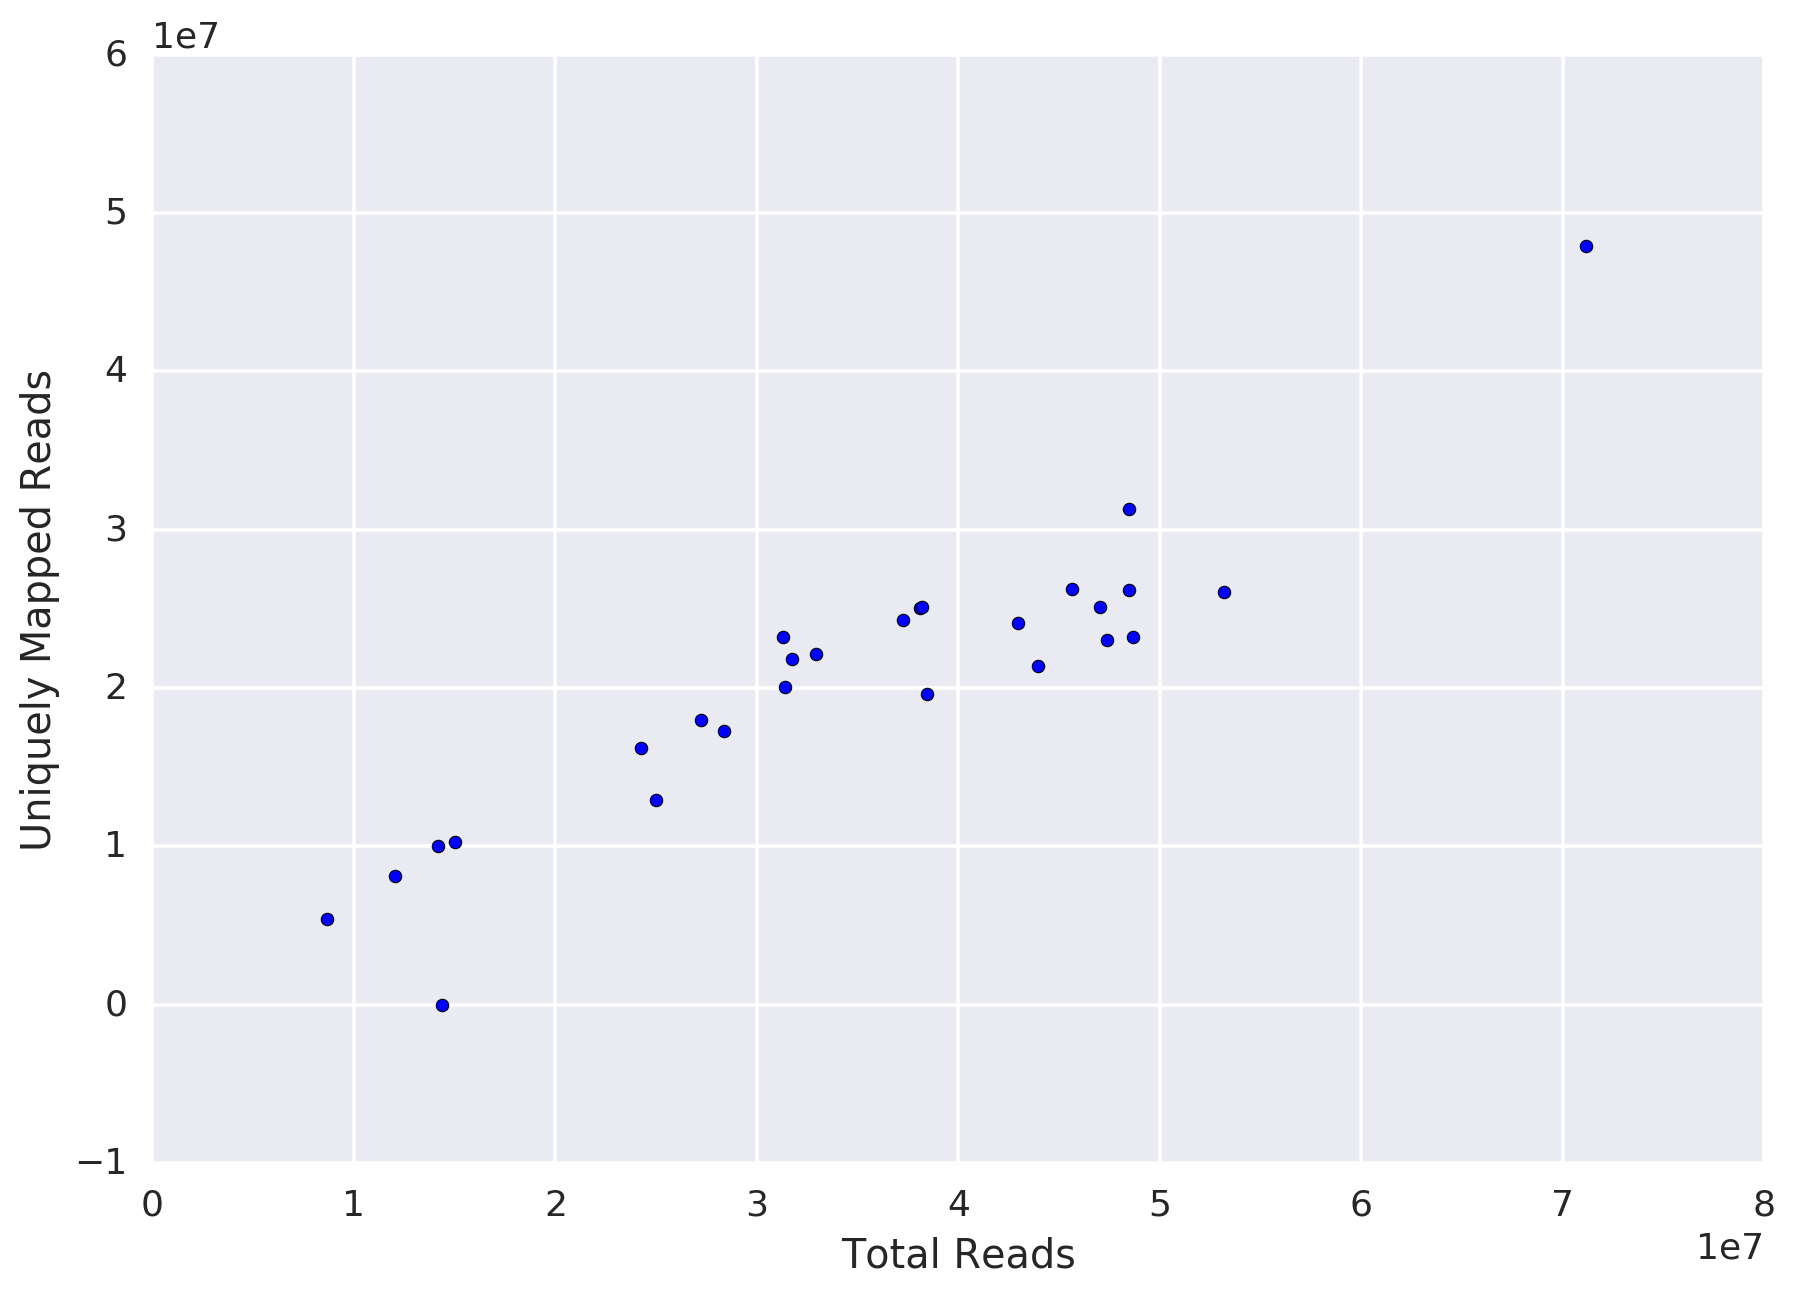

In [88]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_atac_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_atac_frame['clonality'].values, bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()


# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_atac_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.show()


plt.scatter(x = summary_atac_frame['totalReads'].astype(float).values, y=summary_atac_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Total Reads')
plt.ylabel('Uniquely Mapped Reads')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [90]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = -1
uniquelyMappedReadThreshold = -1

filtered_summary_atac_frame = summary_atac_frame.copy()
# # filter on fraction of mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['mappedFraction'] >= mappedFractionThreshold]
# # filter on total mapped reads
# filtered_summary_atac_frame = filtered_summary_atac_frame[filtered_summary_atac_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_atac_frame['sample'].values if not x in filtered_summary_atac_frame['sample'].values]
discarded_summary_atac_frame = summary_atac_frame[summary_atac_frame['sample'].isin(discardedSampleNames)]
print("Number of Samples:", summary_atac_frame.shape[0])
print("Number of discarded samples:",discarded_summary_atac_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_atac_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_atac_frame['strain'] 
                            + '_' + filtered_summary_atac_frame['treatment'] 
                            + '_' + filtered_summary_atac_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_atac_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_atac_frame['sample'].values,
                                       filtered_summary_atac_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_atac_frame['simplifiedName'].values,
                                       filtered_summary_atac_frame['sample'].values))



Number of Samples: 27
Number of discarded samples: 0
Number of Samples remaining after filtering: 27


### Peak Calling

In [91]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'atac_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_idr.sh', 'w')
scriptFile2 = open('./peakCalling_homer.sh', 'w')

atacTagDirPath = './tag_directories_atac/'
for tagDir in filtered_summary_atac_frame['sample'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]

    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"

    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -style factor -size 200  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + atacTagDirPath + '/' + tagDir
                 + ' -style factor -size 200 > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



In [ ]:
%%bash
rm ./atac_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_idr.sh

	Fragment Length = 77
	Total Tags = 23688056.0
	Tags per bp = 0.011844
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 73
	Fragment Length = 77
	Total Tags = 15990733.0
	Tags per bp = 0.007995
	Max tags per bp set automatically to 1.0
	Total Tags = 16739327.0
	Tags per bp = 0.008370
	Max tags per bp set automatically to 1.0
	Fragment Length = 77
	Total Tags = 21056721.0
	Tags per bp = 0.010528
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
	Fragment Length = 67
	Total Tags = 7825213.0
	Tags per bp = 0.003913
	Max tags per bp set automatically to 1.0
	Fragment Length = 71
	Total Tags = 46329172.0
	Tags per bp = 0.023165
	Max tags per bp set automatically to 2.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 78
	Total Tags = 23549529.0
	Tags per bp = 0.011775
	Max tags per bp 

### Run IDR

In [ ]:
idrDirectory = './atac_idr/'
scriptFile = open('./run_idr.sh', 'w')
!rm ./atac_idr/*

! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
replicateIndices = []


# homer peaks
counter = 0
for treatment in sorted(set(filtered_summary_atac_frame['treatment'])):
    samples = filtered_summary_atac_frame[filtered_summary_atac_frame['treatment'] == treatment]['simplifiedName'].values
    
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.01"
            else: 
                commandString += " -threshold 0.01"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

In [ ]:
%%bash
chmod a+x ./scratch/*
bash ./run_idr.sh

/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin/idr --samples ./atac_idr//c57bl6_il4-24h_l20180218-rep1_1_peaks.narrowPeak ./atac_idr//c57bl6_il4-24h_17-07-31-rep2_1_peaks.narrowPeak --output-file ./atac_idr//c57bl6_il4-24h_l20180218-rep1_1_peaks_c57bl6_il4-24h_17-07-31-rep2_1_peaks_idr.out --plot --idr-threshold 0.01
Performing IDR analysis on the following samples: /home/jtao/analysis/genomic_grammar_analysis//atac_peak_files/c57bl6_il4-24h_l20180218-rep1_1_peaks.tsv, /home/jtao/analysis/genomic_grammar_analysis//atac_peak_files/c57bl6_il4-24h_17-07-31-rep2_1_peaks.tsv
Output files will be written to: ./atac_idr/
Using the following IDR threshold: 0.01
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score' 'Score']
idr --samples ./atac_idr//c57bl6_il4-24h_l20180218-rep1_1_peaks.narrowPeak ./atac_idr//c57bl6_il4-24h_17-07-31-rep2_1_peaks.narrowPeak --output-file ./atac_idr//c57bl6_il4-24h_l20180218-rep1_

chmod: cannot access ‘./scratch/*’: No such file or directory
Traceback (most recent call last):
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin/idr", line 4, in <module>
    __import__('pkg_resources').run_script('idr==2.0.3', 'idr')
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pkg_resources/__init__.py", line 750, in run_script
    self.require(requires)[0].run_script(script_name, ns)
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/pkg_resources/__init__.py", line 1527, in run_script
    exec(code, namespace, namespace)
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.3-py3.5-linux-x86_64.egg/EGG-INFO/scripts/idr", line 10, in <module>
    idr.idr.main()
  File "/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/idr-2.0.3-py3.5-linux-x86_64.egg/idr/idr.py", line 828, in main
    merged_peaks, signal_type = load_sampl

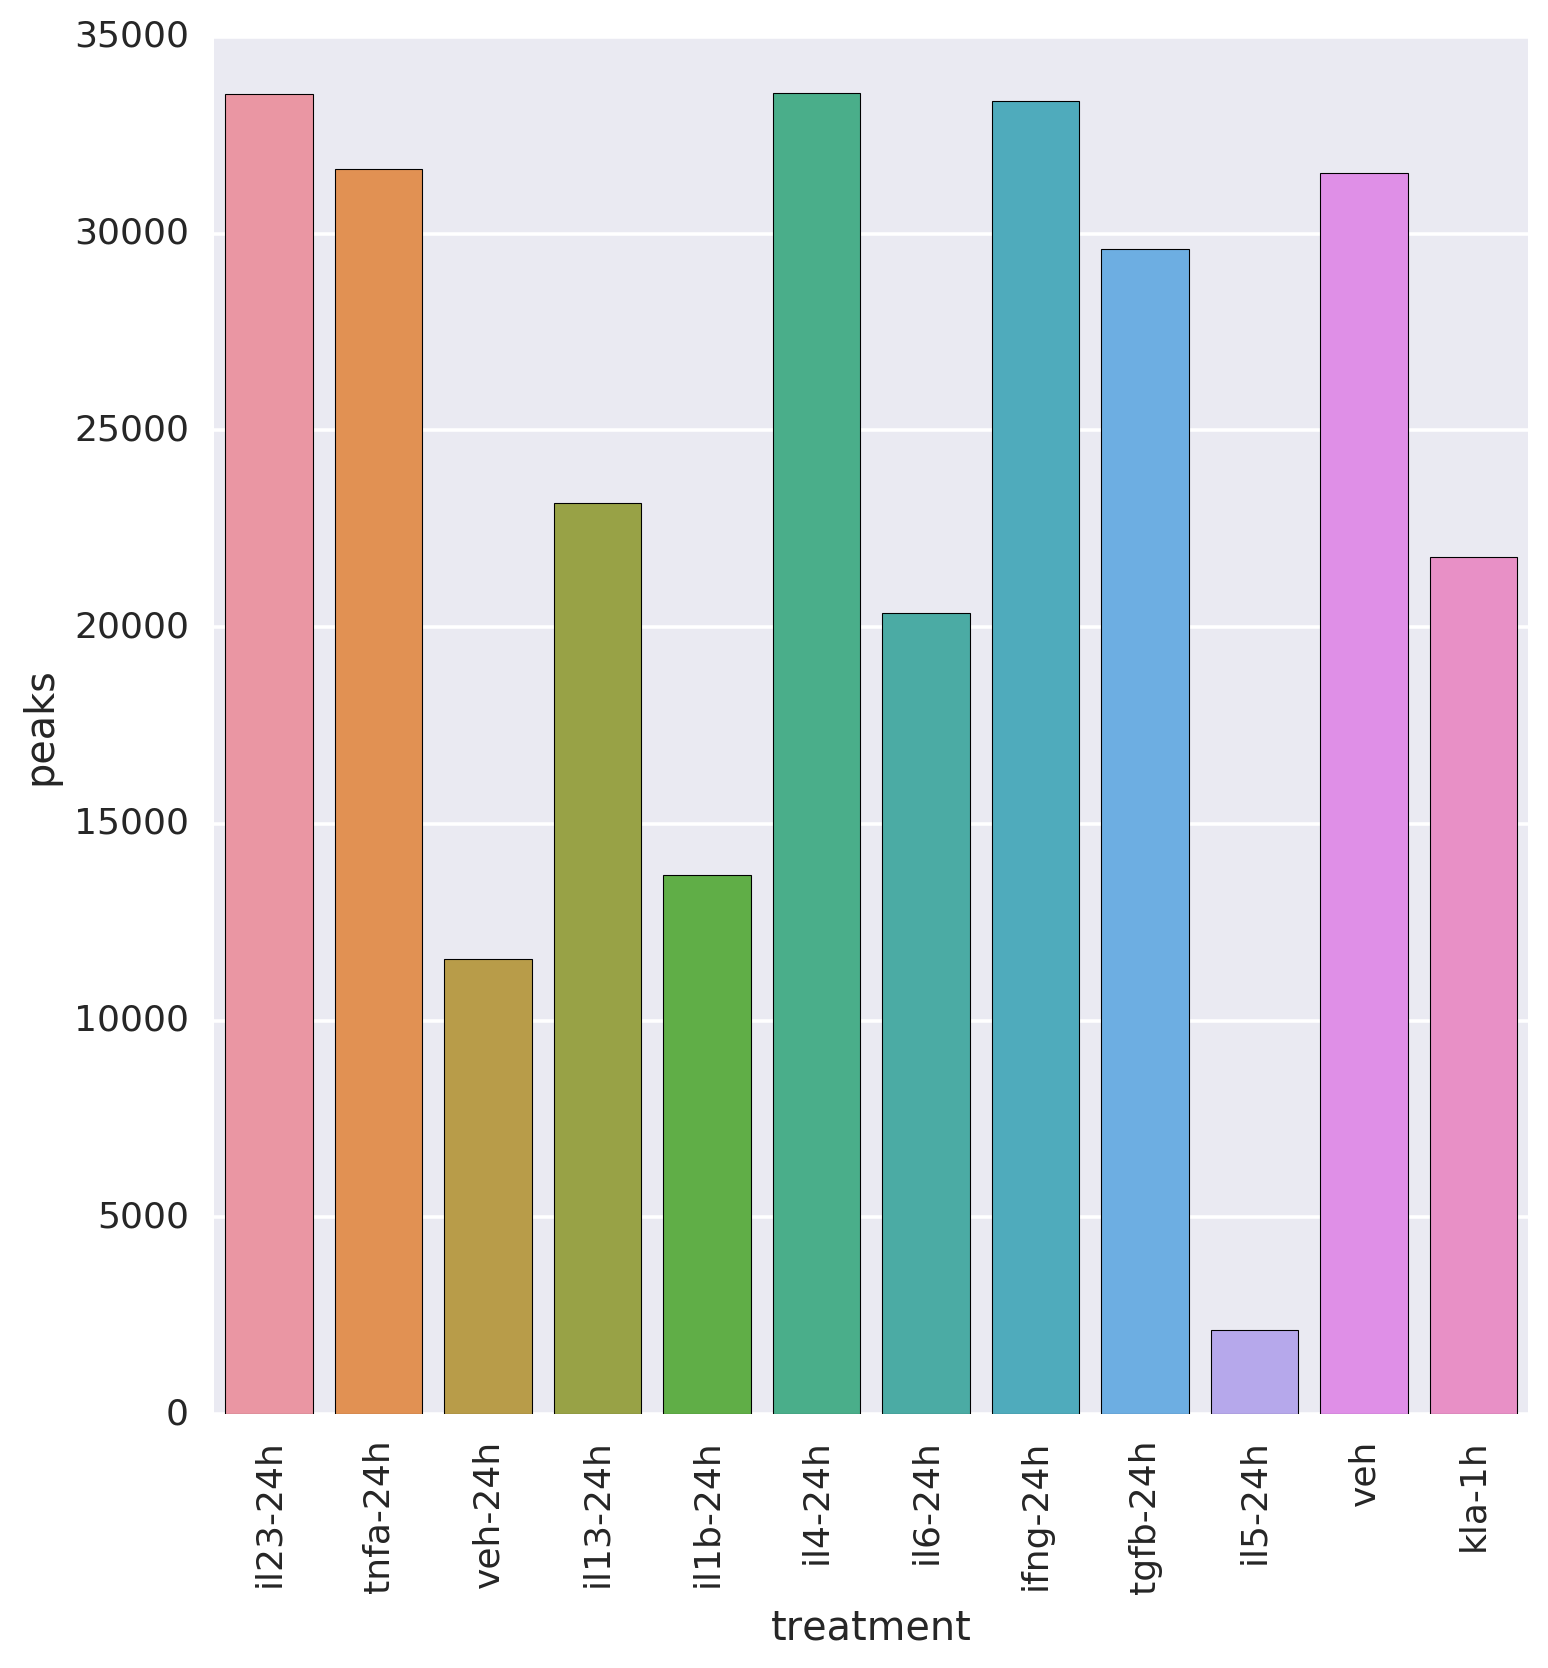

In [ ]:
# pick the IDR results that have the most peaks
idrDirectory = './atac_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = p.split('_')[1]
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p

            factors = []
treatments = []
numPeaks = []
for treatment in treatment_peakNumber_dict.keys():
#     tokens = treatment.split('_')
#     strains.append(tokens[0])
    treatments.append(treatment)
    numPeaks.append(treatment_peakNumber_dict[treatment])

idrPeak_frame = pd.DataFrame({
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['treatment'].values)])
# idrPeak_frame = idrPeak_frame.sort_values(inplace=True)
sns.factorplot(x='treatment', y='peaks', data = idrPeak_frame, size =8, kind='bar')
plt.xticks(rotation=90);
# plt.ylim([0,30000])
    

In [125]:
outFile = open('./best_samples.tsv','w')
if not os.path.isdir('./atac_idr_peaks/'):
    os.mkdir('./atac_idr_peaks/')
else:
    for f in os.listdir('./atac_idr_peaks/'):
        os.remove('./atac_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[1]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    outFile.write('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key]),'\n']))
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './atac_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()




c57bl6	ifng-24h	C57Bl6_BMDM_ATAC_IFNg-24h_GJF_l20180218-rep1	C57Bl6_BMDM_ATAC_IFNg-24h_GJF_l20180305-rep2	c57bl6_ifng-24h_l20180218-rep1_1_peaks_c57bl6_ifng-24h_l20180305-rep2_1_peaks_idr.tsv
c57bl6	il13-24h	C57Bl6_BMDM_ATAC_IL13-24h_GJF_l20180218-rep1	C57Bl6_BMDM_ATAC_IL13-24h_GJF_l20180305-rep2	c57bl6_il13-24h_l20180218-rep1_1_peaks_c57bl6_il13-24h_l20180305-rep2_1_peaks_idr.tsv
c57bl6	il1b-24h	C57Bl6_BMDM_ATAC_IL1B-24h_GJF_l20180218-rep1	C57Bl6_BMDM_ATAC_IL1B-24h_GJF_l20180305-rep2	c57bl6_il1b-24h_l20180218-rep1_1_peaks_c57bl6_il1b-24h_l20180305-rep2_1_peaks_idr.tsv
c57bl6	il23-24h	C57Bl6_BMDM_ATAC_IL23-24h_GJF_l20180218-rep1	C57Bl6_BMDM_ATAC_IL23-24h_GJF_l20180305-rep2	c57bl6_il23-24h_l20180218-rep1_1_peaks_c57bl6_il23-24h_l20180305-rep2_1_peaks_idr.tsv
c57bl6	il4-24h	C57Bl6_BMDM_ATAC_IL4-24h_GJF_l20180218-rep1	C57Bl6_BMDM_ATAC_IL4-24h_GJF_l20180305-rep2	c57bl6_il4-24h_l20180218-rep1_1_peaks_c57bl6_il4-24h_l20180305-rep2_1_peaks_idr.tsv
c57bl6	il5-24h	C57Bl6_BMDM_ATAC_IL5-24h_GJF_l

In [114]:
# create track hub containing best samples
tagDirectories = []
# for key in sorted(treatment_bestIDR_dict.keys()):
for key in treatment_bestIDR_dict.keys():
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    factor = tokens[1]
    treatment = tokens[2]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    tagDirectories.append(sample1)
    tagDirectories.append(sample2)
tagDirectories = ['./tag_directories_atac/'+x for x in tagDirectories]
tagDirString = ' '.join(tagDirectories)
! echo makeMultiWigHub.pl signals_atac mm10 -force -d $tagDirString -fragLength 150
! makeMultiWigHub.pl signals_atac mm10 -force -fragLength 150 -d $tagDirString

makeMultiWigHub.pl signals_atac mm10 -force -d ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL23-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL23-24h_GJF_l20180305-rep2 ./tag_directories_atac/C57Bl6_BMDM_ATAC_TNFa-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_TNFa-24h_GJF_l20180305-rep2 ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh-24h_GJF_l20180305-rep2 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL13-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL13-24h_GJF_l20180305-rep2 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL1B-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL1B-24h_GJF_l20180305-rep2 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-24h_GJF_l20180305-rep2 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL6-24h_GJF_l20180218-rep1 ./tag_directories_atac/C57Bl6_BMDM_ATAC_IL6-24h_GJF_l20180305-rep2 ./tag_d

## Merge Peak Files

In [7]:
target_peak_size = 75

if not os.path.isdir('./resized_peak_files'):
    os.mkdir('./resized_peak_files')
else:
    for rpf in os.listdir('./resized_peak_files'):
        os.remove('./resized_peak_files/' + rpf)

for pf in os.listdir('./atac_idr_peaks/'):
    current_peak_frame = pd.read_csv('./atac_idr_peaks/' + pf, sep='\t' )
    peakCenters = (current_peak_frame['start'] + current_peak_frame['end']) /2
    int_peakCenters = np.ceil(peakCenters).astype(int)
    new_starts = int_peakCenters - int(target_peak_size/2)
    new_ends = int_peakCenters + int(target_peak_size/2)
    current_peak_frame['start'] = new_starts
    current_peak_frame['end'] = new_ends
    current_peak_frame.to_csv('./resized_peak_files/' + pf, sep='\t', index=False)

In [8]:
%%capture
! mergePeaks -d given -venn venn.txt ./resized_peak_files/* > ./merged_atac_peaks.tsv

In [9]:
merged_frame = pd.read_csv('./merged_atac_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 150
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t', index=False)

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Annotate peaks

#### ATAC

In [10]:
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -d ./tag_directories_atac/*/ > ./annotated_atac_peaks.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Tag Directories:
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15/
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06/
	Peak/BED file con

#### H3k27Ac

In [5]:
!annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -size 500 -d ./tag_directories_enhancer_marks/*/ > ./merged_atac_annotated_h3k27ac_peaks.tsv
!annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -pc 1 -size 500 -d ./tag_directories_enhancer_marks/*/ > ./merged_atac_annotated_h3k27ac_nodups_peaks.tsv



	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Maximum count per bp will be set to 1
	Peak Region set to 500
	Tag Directories:
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_IL4-24h_MAH_l20171004/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_IL4-24h_MAH_l20171129/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27Ac_KLA-1h_BC_16-04-15-rep1/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27Ac_KLA-1h_BC_16-04-15-rep2/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_Veh_MAH_l20171004/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_Veh_MAH_l20171121/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 54771
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 54771
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with mi

In [58]:
! makeSummaryFile.py ./merged_atac_peaks_filtered_resized.tsv ./group_atac_summary.tsv ./resized_peak_files/*

Finished reading merged peak file...
Integrating scores for c57bl6_ifng-1h
Integrating scores for c57bl6_il4-1h
Integrating scores for c57bl6_kla-1h
Integrating scores for c57bl6_pamcsk-1h
Integrating scores for c57bl6_r848-1h
Integrating scores for c57bl6_tgfbeta-1h
Integrating scores for c57bl6_veh


In [61]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['ID'].values

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
summary_frame.to_pickle('summary_frame.pickle')

## Calculate Differential ATAC-seq peaks

In [82]:
tag_dirs = sorted(os.listdir('./tag_directories_atac/'))
treated_dirs = ' '.join(['./tag_directories_atac/' + x for x in tag_dirs if not '_Veh_' in x])
veh_dirs = ' '.join(['./tag_directories_atac/' +x for x in tag_dirs if  '_Veh_' in x])
! annotatePeaks.pl ./merged_atac_peaks_filtered_resized.tsv mm10 -raw -d $veh_dirs $treated_dirs > ./annotated_atac_peaks_raw.tsv


	Peak file = ./merged_atac_peaks_filtered_resized.tsv
	Genome = mm10
	Organism = mouse
	Will NOT normalize tag counts
	Tag Directories:
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-02-11-and-16-09-15
		./tag_directories_atac/C57Bl6_BMDM_ATAC_Veh_BC_16-05-06
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD340
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IFNg-1h_SD_SD341
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD336
		./tag_directories_atac/C57Bl6_BMDM_ATAC_IL4-1h_SD_SD337
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-02-11-and-16-09-15
		./tag_directories_atac/C57Bl6_BMDM_ATAC_KLA-1h_BC_16-05-06
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD342
		./tag_directories_atac/C57Bl6_BMDM_ATAC_PamCSK-1h_SD_SD343
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD344
		./tag_directories_atac/C57Bl6_BMDM_ATAC_R848-1h_SD_SD345
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD338
		./tag_directories_atac/C57Bl6_BMDM_ATAC_TGFbeta-1h_SD_SD339
	

In [83]:
with open('./annotated_atac_peaks_raw.tsv') as f:
    data = f.readline()
conditions = [x.split('/')[2].split('_')[3] for x in data.split('\t')[19:]]
condition_string = ' '.join(conditions)
!getDiffExpression.pl ./annotated_atac_peaks_raw.tsv $condition_string -AvsA > edgeR_atac_out.tsv


	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected annotatePeaks.pl file
	Output Stats Veh vs. IFNg-1h:
		Total Genes: 54859
		Total Up-regulated in IFNg-1h vs. Veh: 4219 (7.691%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IFNg-1h vs. Veh: 5087 (9.273%) [log2fold<-1, FDR<0.05]
	Output Stats Veh vs. IL4-1h:
		Total Genes: 54859
		Total Up-regulated in IL4-1h vs. Veh: 2181 (3.976%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in IL4-1h vs. Veh: 2898 (5.283%) [log2fold<-1, FDR<0.05]
	Output Stats Veh vs. KLA-1h:
		Total Genes: 54859
		Total Up-regulated in KLA-1h vs. Veh: 1420 (2.588%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in KLA-1h vs. Veh: 366 (0.667%) [log2fold<-1, FDR<0.05]
	Output Stats Veh vs. PamCSK-1h:
		Total Genes: 54859
		Total Up-regulated in PamCSK-1h vs. Veh: 4991 (9.098%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in PamCSK-1h vs. Veh: 6137 (11.187%) [log2fold<-

## Calculate Motif Scores

In [116]:
%%bash
if [ ! -d ./peak_sequences ] ;
    then mkdir ./peak_sequences
else
    rm ./peak_sequences/*
fi

rm: cannot remove ‘./peak_sequences/*’: No such file or directory


In [117]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_atac_peaks_filtered_resized.tsv > ./tmp
tail -n +2 ./tmp > ./merged_atac_peaks_filtered_resized.bed
rm tmp


	Converted 54771 peaks total



In [119]:
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/extract_sequences.py ./merged_atac_peaks_filtered_resized.bed mm10 ./merged_atac_peaks_filtered_resized.fasta

reading genome mm10


## Generate background

In [127]:
!/home/jtao/code/tba/model_training/generate_background_coordinates.py ./merged_atac_peaks_filtered_resized.bed mm10 ./

filtering out: chrM chrY
reading genome mm10
done reading genome
0 0
target GC: 0.40041037960885784 background GC: 0.39855913302169993 target length: 201 numTargetPositions 5478 backgroundPositions 5478
0 0
target GC: 0.44257628758014855 background GC: 0.4396666889620827 target length: 201 numTargetPositions 5477 backgroundPositions 5477
0 0
target GC: 0.4657741540813229 background GC: 0.46176721013342376 target length: 201 numTargetPositions 5477 backgroundPositions 5477
0 0
target GC: 0.48472177321156007 background GC: 0.48033902349514895 target length: 201 numTargetPositions 5477 backgroundPositions 5477
0 0
target GC: 0.5030326273477757 background GC: 0.49830795568140956 target length: 201 numTargetPositions 5477 backgroundPositions 5477
0 0
target GC: 0.5227505413637907 background GC: 0.5137541871769331 target length: 201 numTargetPositions 5477 backgroundPositions 5477
0 0
target GC: 0.5465697306266066 background GC: 0.5354588133634863 target length: 201 numTargetPositions 5477 b

### All Motif Scores

In [122]:
# calculate motif scores
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/calculate_all_motif_scores.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./motif_scores /gpfs/data01/glasslab/home/jtao/code/tba/default_motifs/*jaspar

Arid3a calculation time: 6.360261678695679
Ahr::Arnt calculation time: 7.27443528175354
BARHL2 calculation time: 9.730804920196533
AP-2_2_merged calculation time: 10.778937578201294
Dux calculation time: 8.009639263153076
Arid3b calculation time: 11.931458950042725
CEBP-related_2_merged calculation time: 11.283847332000732
CEBP-related_1_merged calculation time: 12.583008527755737
CEBPA calculation time: 12.362027168273926
Arid5a calculation time: 13.410557270050049
Bcl6 calculation time: 12.944523572921753
DMRT3 calculation time: 11.673742532730103
E2F-related_1_merged calculation time: 11.308987617492676
AP-2_1_merged calculation time: 14.571696281433105
Bach1::Mafk calculation time: 13.9734947681427
CREB1 calculation time: 12.70511245727539
E2F1 calculation time: 11.48635458946228
CP2-related_1_merged calculation time: 13.705713748931885
BCL6B calculation time: 14.928110599517822
EBF1 calculation time: 12.57084345817566
ATF4 calculation time: 16.7510883808136
Ddit3::Cebpa calculatio

### Top Motif Scores

In [124]:
# calculate motif scores
!rm -r ./motif_scores
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/calculate_motif_scores_biopython.py -num_procs 28 ./merged_atac_peaks_filtered_resized.fasta ./top_motif_scores /gpfs/data01/glasslab/home/jtao/code/tba/default_motifs/*jaspar

rm: cannot remove ‘./motif_scores’: No such file or directory
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
Arid3a calculation time: 7.423861026763916
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
Ahr::Arnt calculation time: 8.281291723251343
/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/gpfs/data01/

# ChIP-Seq

In [38]:
summary_chip_frame = pd.read_csv('./qc_chip/mapping_stats.tsv', sep='\t')
summary_chip_frame['genome'] = 'mm10'
sample_names = summary_chip_frame['sample'].values
summary_chip_frame['strain'] = [x.split('_')[0] for x in sample_names]
summary_chip_frame['date'] = [x.split('_')[5] for x in sample_names]
summary_chip_frame['treatment'] = [x.split('_')[3] for x in sample_names]



### Mapping Quality Control

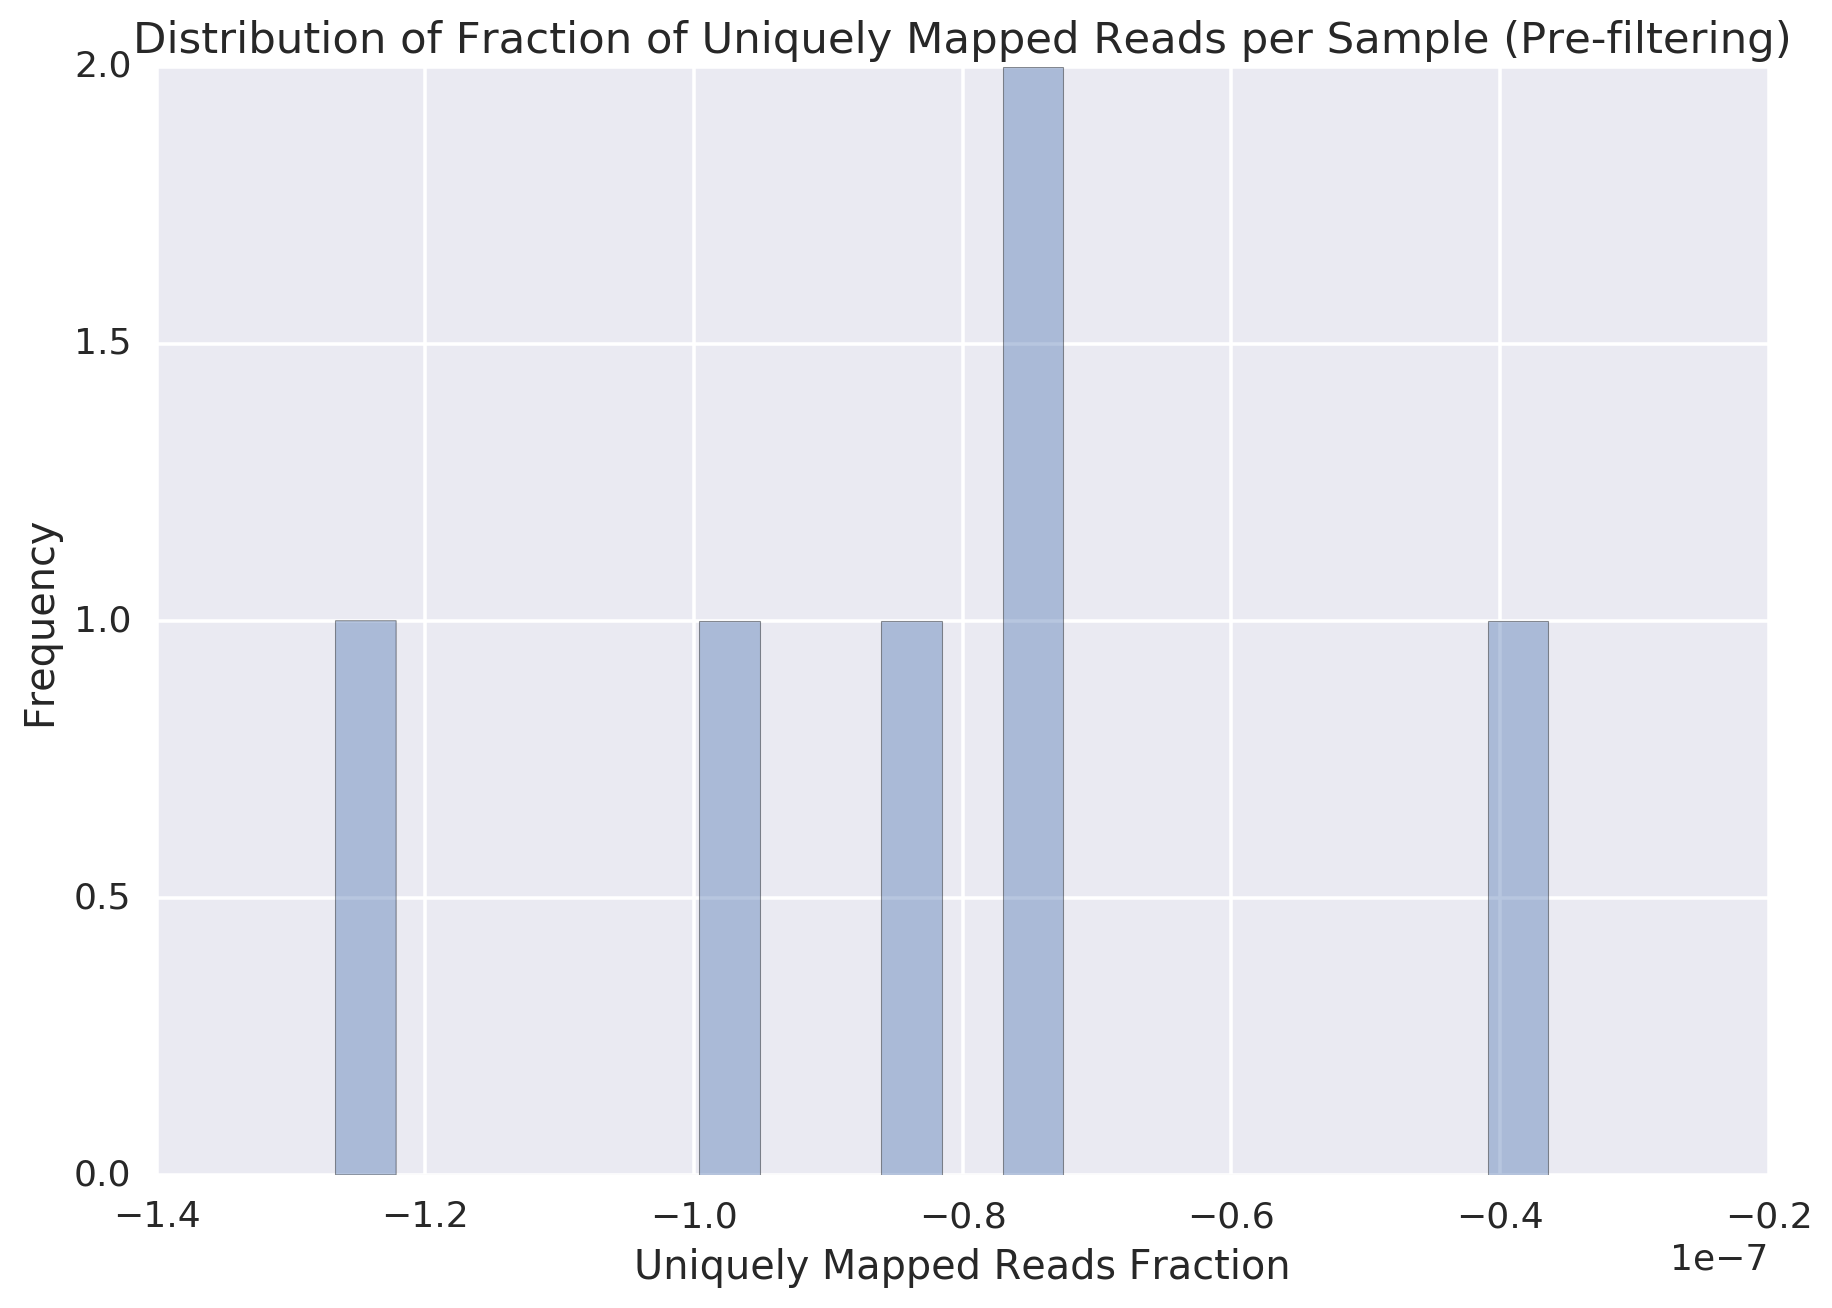

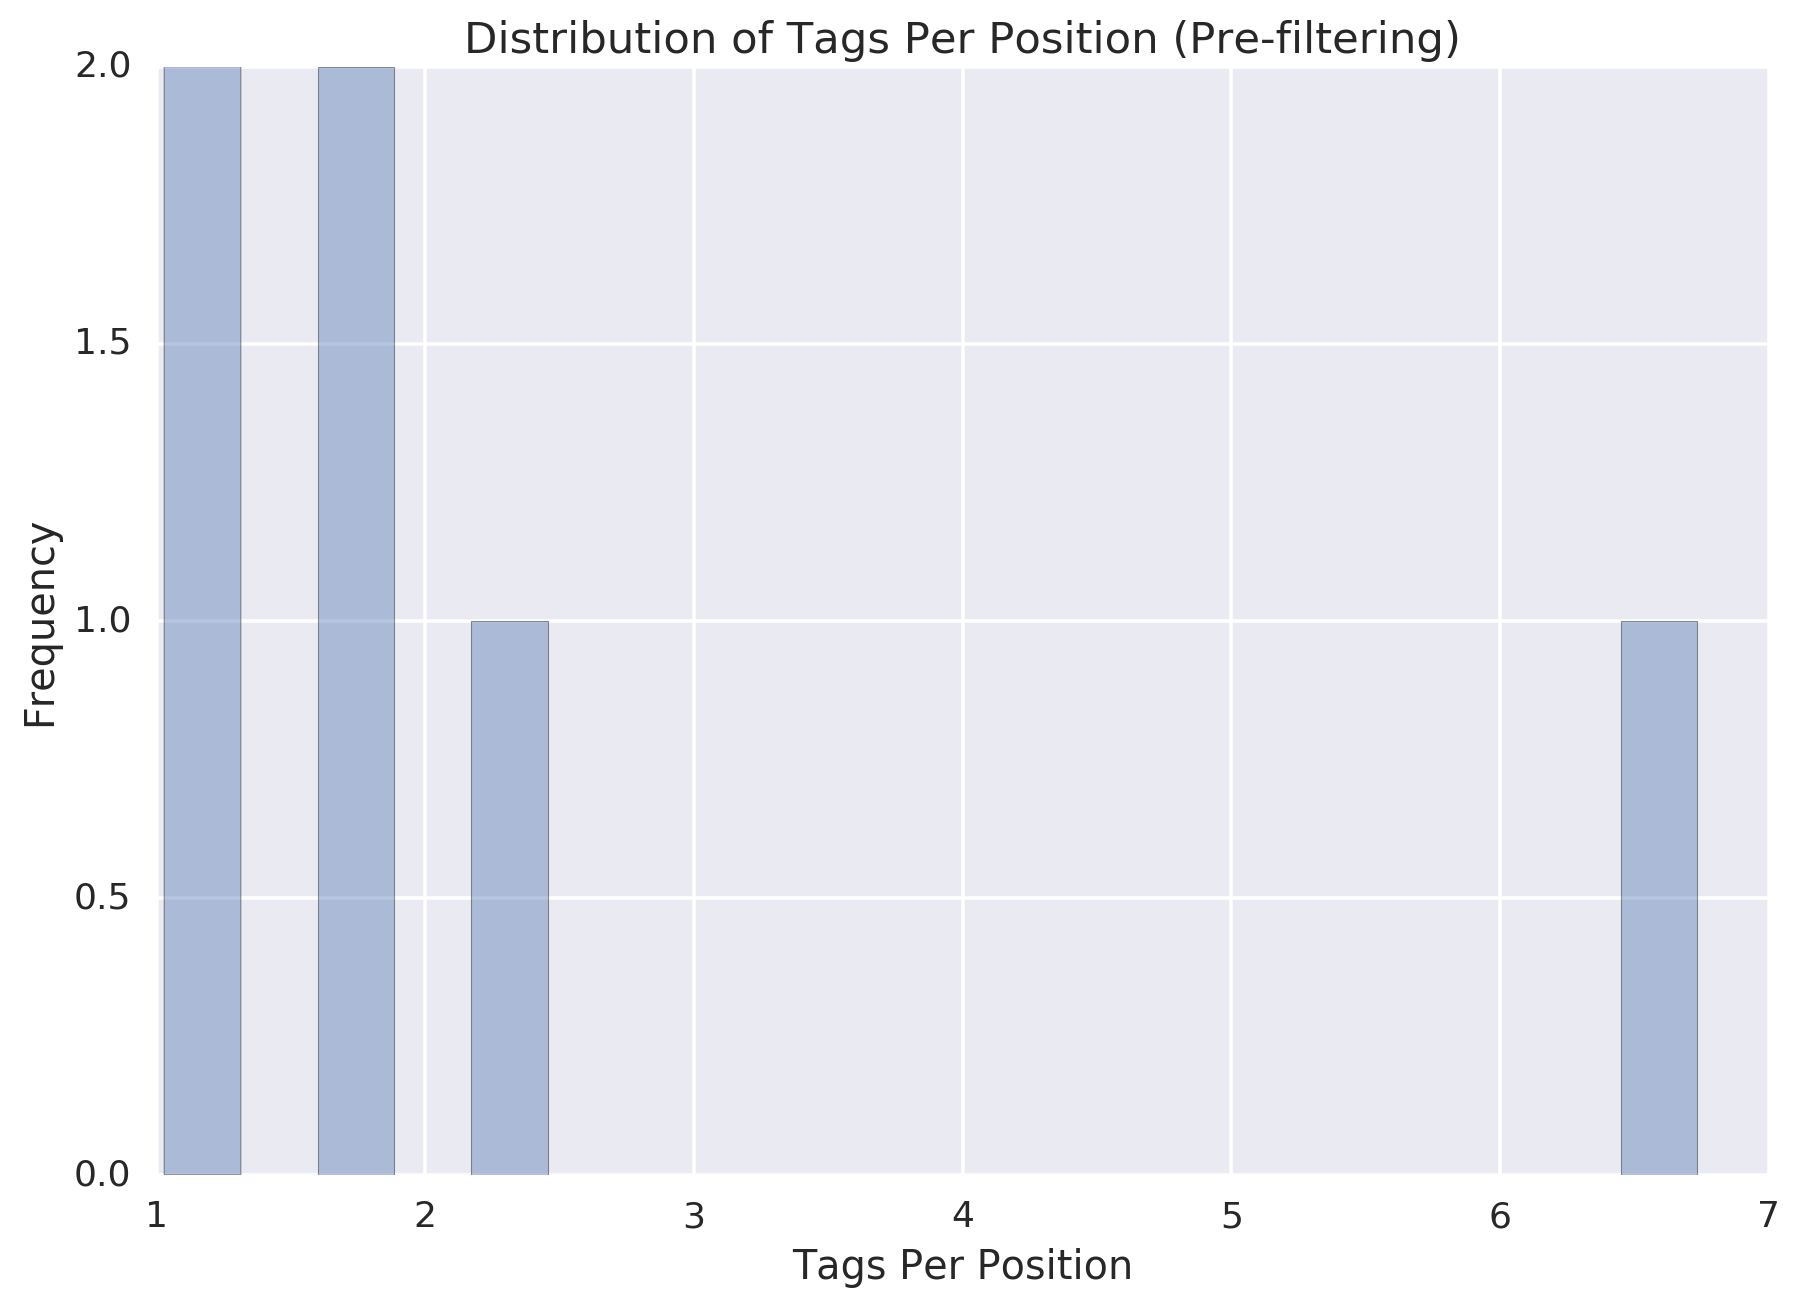

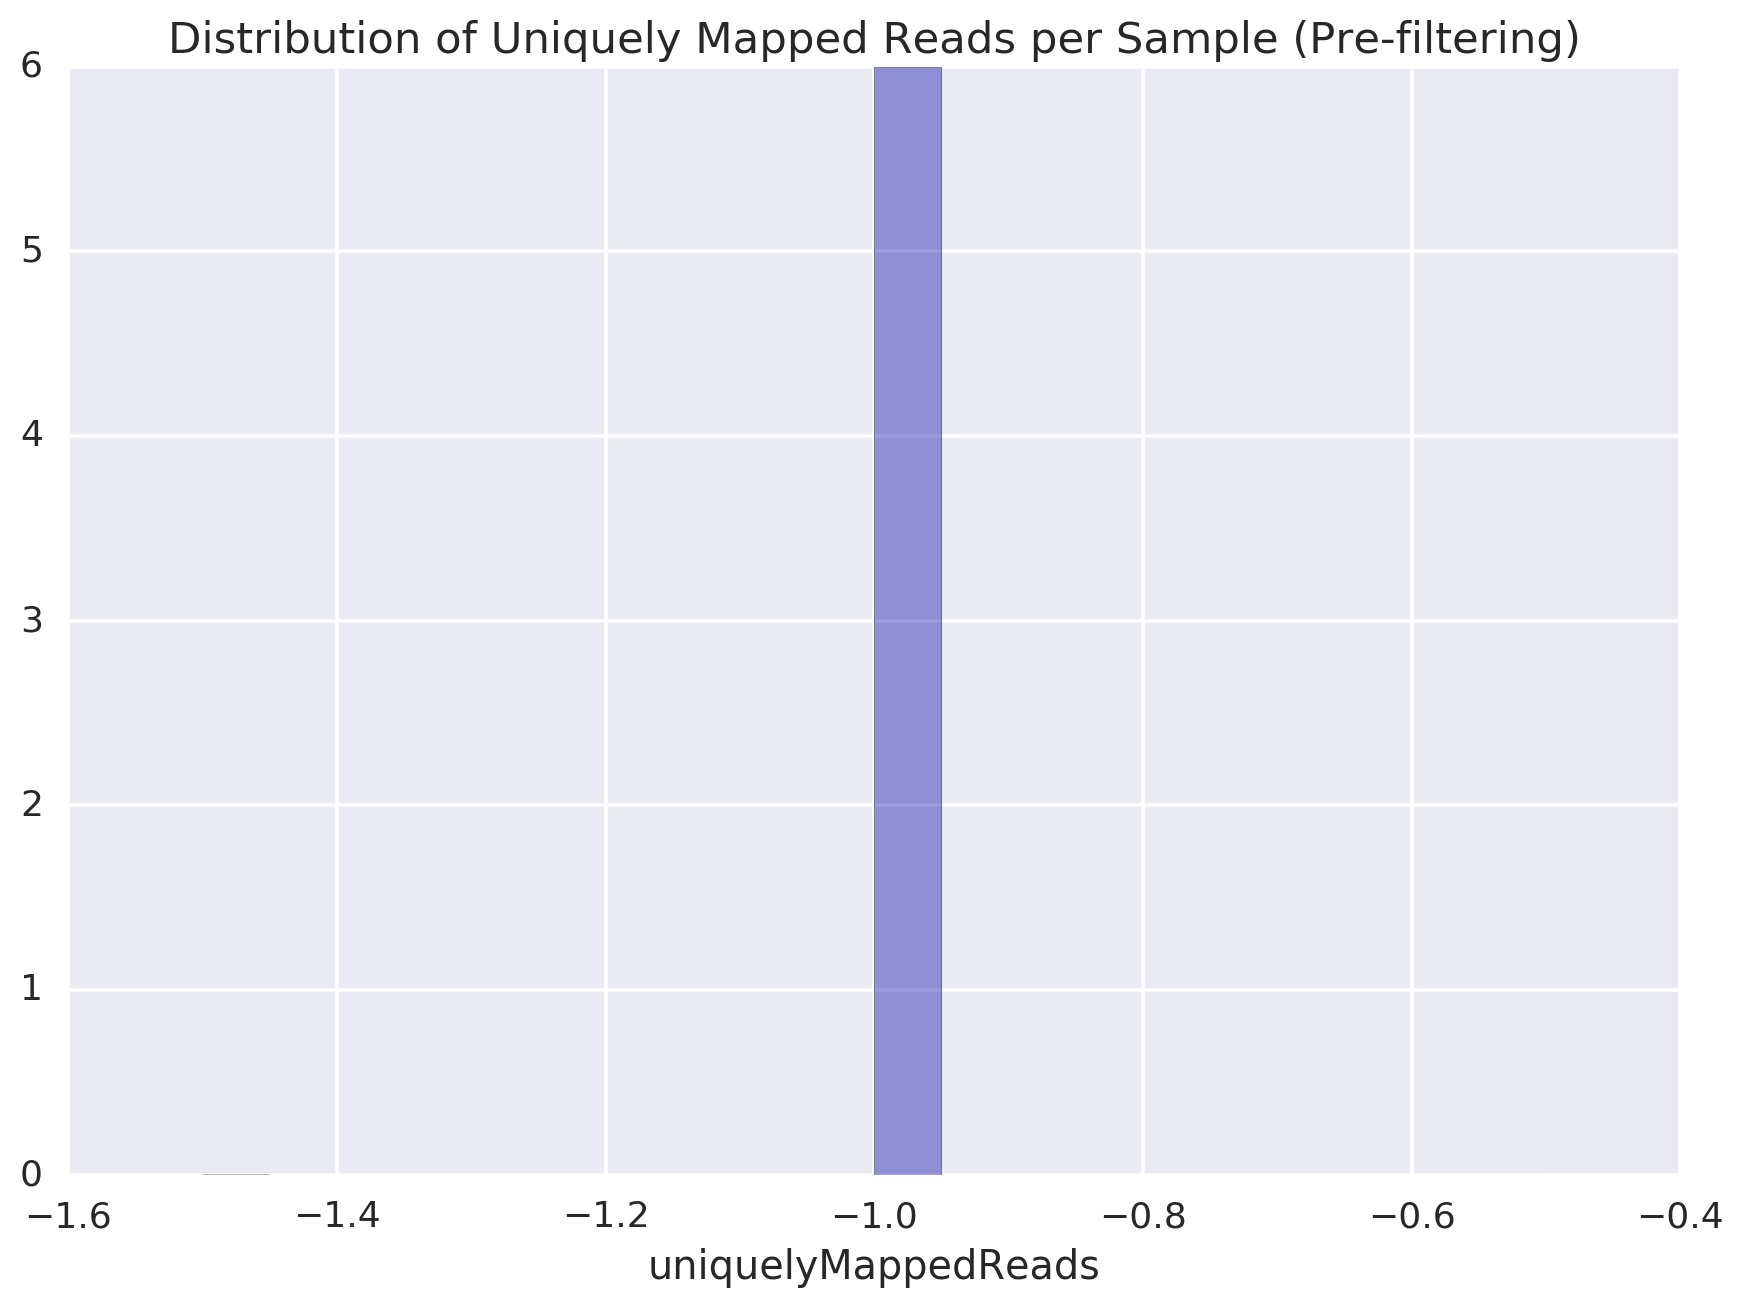

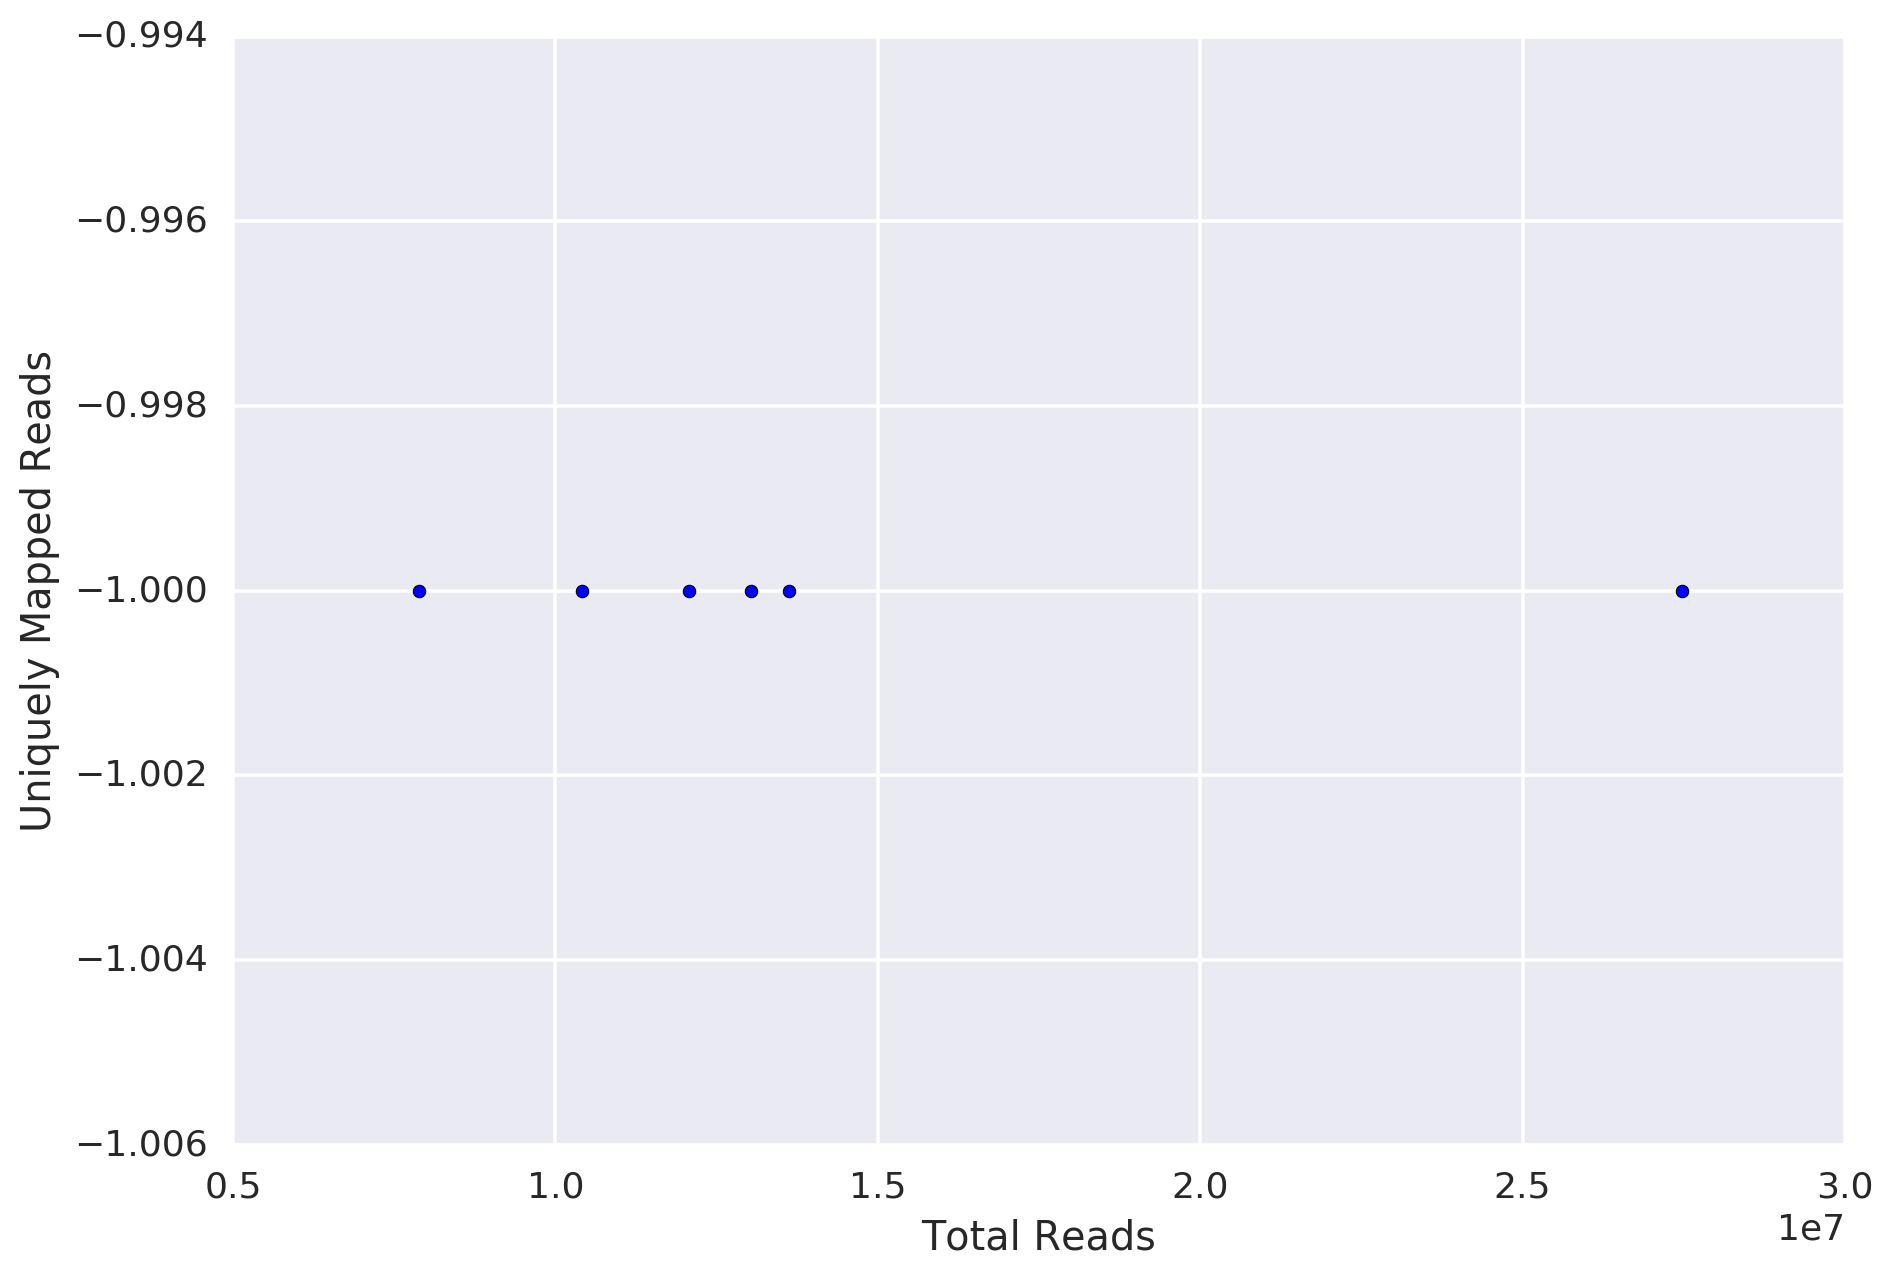

In [39]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_chip_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_chip_frame['clonality'].values, bins=20, kde=False)
plt.title('Distribution of Tags Per Position (Pre-filtering)')
plt.xlabel('Tags Per Position')
plt.ylabel('Frequency')
plt.show()


# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_chip_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.show()


plt.scatter(x = summary_chip_frame['totalReads'].astype(float).values, y=summary_chip_frame['uniquelyMappedReads'].astype(float).values)
plt.xlabel('Total Reads')
plt.ylabel('Uniquely Mapped Reads')
# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

### Filter Samples According to Mapping Quality

In [40]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.0
uniquelyMappedReadThreshold = 0

filtered_summary_chip_frame = summary_chip_frame.copy()
# # filter on fraction of mapped reads
# filtered_summary_chip_frame = filtered_summary_chip_frame[filtered_summary_chip_frame['mappedFraction'] >= mappedFractionThreshold]
# # filter on total mapped reads
# filtered_summary_chip_frame = filtered_summary_chip_frame[filtered_summary_chip_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]

# get samples that were discarded
discardedSampleNames = [x for x in summary_chip_frame['sample'].values if not x in filtered_summary_chip_frame['sample'].values]
discarded_summary_chip_frame = summary_chip_frame[summary_chip_frame['sample'].isin(discardedSampleNames)]
print("Number of Samples:", summary_chip_frame.shape[0])
print("Number of discarded samples:",discarded_summary_chip_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_chip_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_chip_frame['strain'] 
                            + '_' + filtered_summary_chip_frame['treatment'] 
                            + '_' + filtered_summary_chip_frame['date']).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

filtered_summary_chip_frame["simplifiedName"] = simplifiedNames

originalName_simpleName_dict = dict(zip(filtered_summary_chip_frame['sample'].values,
                                       filtered_summary_chip_frame['simplifiedName'].values))
simpleName_originalName_dict = dict(zip(filtered_summary_chip_frame['simplifiedName'].values,
                                       filtered_summary_chip_frame['sample'].values))



Number of Samples: 6
Number of discarded samples: 0
Number of Samples remaining after filtering: 6


### Peak Calling

In [45]:
# %%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
peakDirectory = workingDirectory + '/' + 'chip_peak_files'

if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile1 = open('./peakCalling_homer_chip_idr.sh', 'w')
scriptFile2 = open('./peakCalling_homer_chip.sh', 'w')

atacTagDirPath = './tag_directories_chip/'
for tagDir in filtered_summary_chip_frame['sample'].values:
    # call peaks only for experiments that passed thresholding
    metaDataTokens = tagDir.split("_")
    treatment = metaDataTokens[4]
    print(treatment)
    if treatment == 'KLA-1h':
        inputDir = './input_tag_directories/C57Bl6_BMDM_ChIP_Input_KLA-1h_MAH_l20170712/'
    elif treatment == 'Veh':
        inputDir = './input_tag_directories/C57Bl6_BMDM_ChIP_Input_Veh_MAH_l20171004/'
    peakFileName1 = originalName_simpleName_dict[tagDir] + "_peaks.tsv"
    peakFileName2 = originalName_simpleName_dict[tagDir] + "_default_peaks.tsv"
    
    scriptFile1.write('findPeaks ' + atacTagDirPath + '/' + tagDir 
                     + ' -L 0 -C 0 -fdr 0.9' 
                     + ' -i ' + inputDir 
                     + ' -style factor -size 200  > ' + 
                     peakDirectory + '/' + peakFileName1 + ' &\n')
    scriptFile2.write('findPeaks ' + atacTagDirPath + '/' + tagDir
                      + ' -i ' + inputDir
                      + ' -style factor -size 200 > ' + 
                 peakDirectory +'/' + peakFileName2 + ' &\n')
scriptFile1.close()
scriptFile2.close()



Veh
Veh
KLA-1h
KLA-1h
KLA-1h
KLA-1h


In [46]:
%%bash
rm ./chip_peak_files/*
chmod a+x ./*sh
bash ./peakCalling_homer_chip_idr.sh

rm: cannot remove ‘./atac_peak_files/*’: No such file or directory
	Fragment Length = 173
	Total Tags = 13626752.0
	Tags per bp = 0.006813
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 180
	Total Tags = 7893494.0
	Tags per bp = 0.003947
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 170
	Total Tags = 13032935.0
	Tags per bp = 0.006516
	Max tags per bp set automatically to 1.0
	Fragment Length = 146
	Total Tags = 27469954.0
	Tags per bp = 0.013735
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Fragment Length = 135
	Total Tags = 12080219.0
	Tags per bp = 0.006040
	Max tags per bp set automatically to 1.0
	Finding peaks of size 200, no closer than 400
	Finding peaks of size 200, no closer than 400
	Fragment Length = 133
	Total Tags = 10421053.0
	Tags per bp = 0.005211
	Max tags per bp set automatically to 1.0
	Finding peaks 

### Run IDR

In [48]:
idrDirectory = './chip_idr/'
scriptFile = open('./run_idr_chip.sh', 'w')


! if [ ! -d $idrDirectory ]; then mkdir $idrDirectory; fi
!rm ./atac_chip/*
replicateIndices = []


# homer peaks
counter = 0
for treatment in sorted(set(filtered_summary_chip_frame['treatment'])):
    samples = filtered_summary_chip_frame[filtered_summary_chip_frame['treatment'] == treatment]['simplifiedName'].values
    
    for i in range(len(samples) - 1):
        for j in range(i+1, len(samples)):
            counter += 1
            sample1 = samples[i]
            sample2 = samples[j]
            peakFile1 = peakDirectory + '/' + sample1 + '_peaks.tsv'
            peakFile2 = peakDirectory + '/' + sample2 + '_peaks.tsv'
            
            # determine IDR threshold based on number of peaks
            # https://sites.google.com/site/anshulkundaje/projects/idr
            with open(peakFile1) as f:
                data = f.readlines()
            len_1 = len(data)
            with open(peakFile2) as f:
                data = f.readlines()
            len_2 = len(data)
            max_length = max(len_1, len_2)
            commandString = ' '.join(['python /home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py',
                                     peakFile1,
                                     peakFile2,
                                     idrDirectory])
            if max_length > 150000 + 35: # 35 is the number of header rows in peak files
                commandString += " -threshold 0.01"
            else: 
                commandString += " -threshold 0.05"            
            if not counter % 12 == 0:
                commandString += ' &'
            scriptFile.write(commandString + '\n')
scriptFile.close()

rm: cannot remove ‘./atac_chip/*’: No such file or directory


In [49]:
%%bash
chmod a+x ./*
bash ./run_idr_chip.sh

Performing IDR analysis on the following samples: /home/jtao/analysis/genomic_grammar_analysis//chip_peak_files/c57bl6_p65_bc_1_peaks.tsv, /home/jtao/analysis/genomic_grammar_analysis//chip_peak_files/c57bl6_p65_jss_1_peaks.tsv
Output files will be written to: ./chip_idr/
Using the following IDR threshold: 0.05
Peaks will be ranked using: findPeaks Score
Other available scoreColumns: ['Normalized Tag Count' 'focus ratio' 'findPeaks Score'
 'Total Tags (normalized to Control Experiment)' 'Control Tags'
 'Fold Change vs Control' 'p-value vs Control' 'Score']
idr --samples ./chip_idr//c57bl6_p65_bc_1_peaks.narrowPeak ./chip_idr//c57bl6_p65_jss_1_peaks.narrowPeak --output-file ./chip_idr//c57bl6_p65_bc_1_peaks_c57bl6_p65_jss_1_peaks_idr.out --plot --idr-threshold 0.05 &
Performing IDR analysis on the following samples: /home/jtao/analysis/genomic_grammar_analysis//chip_peak_files/c57bl6_p65_bc_2_peaks.tsv, /home/jtao/analysis/genomic_grammar_analysis//chip_peak_files/c57bl6_p65_jss_1_peaks

Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Initial parameter values: [0.10 1.00 0.20 0.50]
Final parameter values: [1.18 1.20 0.76 0.71]
Final parameter values: [0.89 0.99 0.70 0.72]
Number of reported peaks - 12279/28010 (43.8%)

Number of peaks passing IDR cutoff of 0.05 - 12279/28010 (43.8%)

Number of reported peaks - 9174/26523 (34.6%)

Number of peaks passing IDR cutoff of 0.05 - 9174/26523 (34.6%)

/home/jtao/code/seq_merge_pipe/run_idr_homerPeaks.py:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  narrowPeakFrame

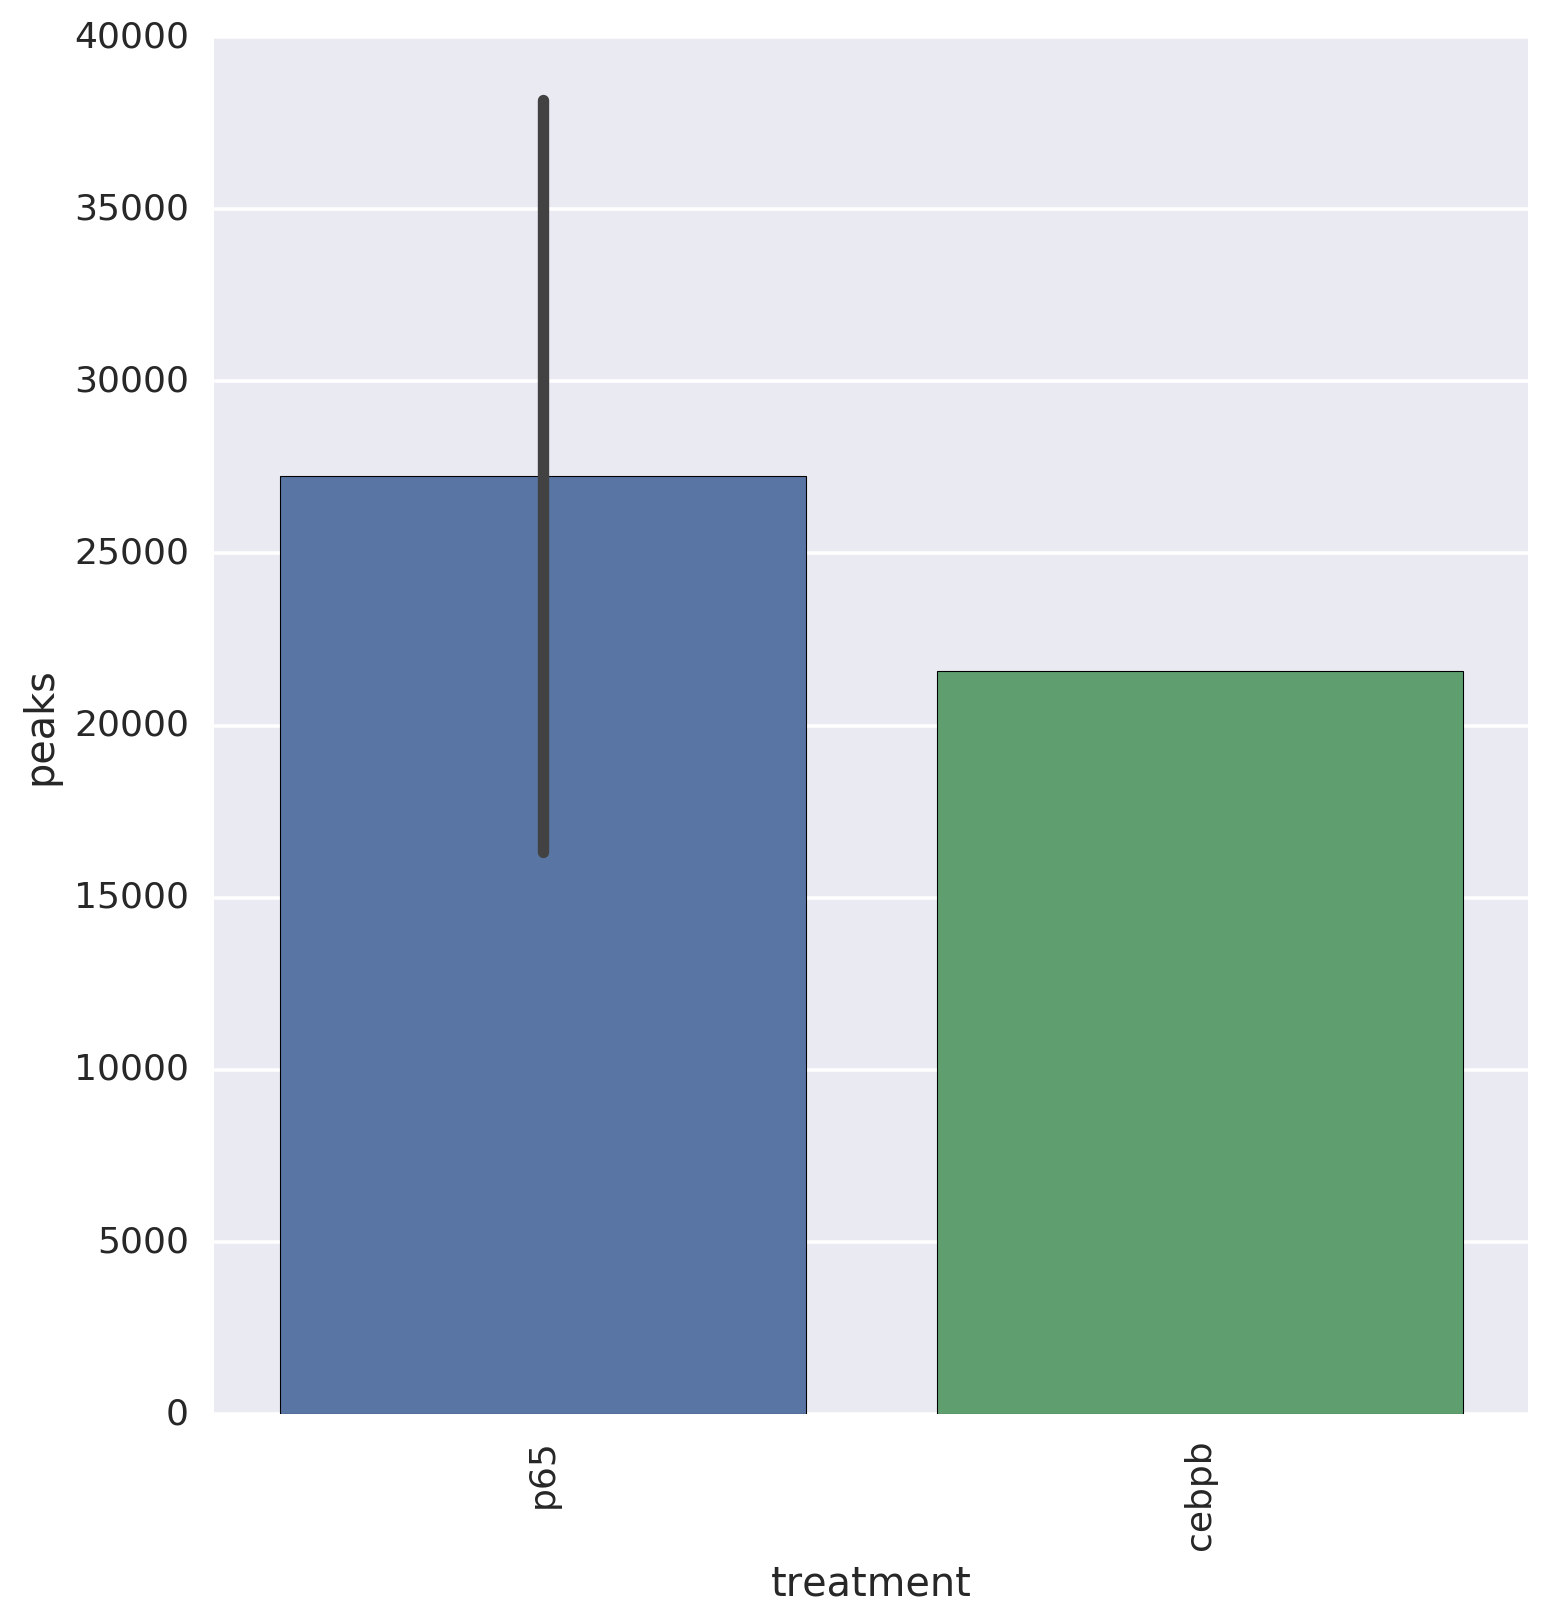

In [50]:
# pick the IDR results that have the most peaks
idrDirectory = './chip_idr/'
treatment_bestIDR_dict = {}
treatment_peakNumber_dict = {}
for p in os.listdir(idrDirectory):
    if 'idr.tsv' in p:
        with open (idrDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 1
        treatment = '_'.join(p.split('_')[:3])
        if treatment in treatment_peakNumber_dict:
            if treatment_peakNumber_dict[treatment] < numPeaks:
                treatment_peakNumber_dict[treatment] = numPeaks
                treatment_bestIDR_dict[treatment] = p
        else:
            treatment_peakNumber_dict[treatment] = numPeaks
            treatment_bestIDR_dict[treatment] = p
strains = []
factors = []
treatments = []
numPeaks = []
for treatment in treatment_peakNumber_dict.keys():
    tokens = treatment.split('_')
    strains.append(tokens[0])
    treatments.append(tokens[1])
    numPeaks.append(treatment_peakNumber_dict[treatment])

idrPeak_frame = pd.DataFrame({'strain':strains,
                 'treatment':treatments,
                 'peaks': numPeaks})
    
idrPeak_frame.index  = pd.MultiIndex.from_arrays([list(idrPeak_frame['strain'].values), list(idrPeak_frame['treatment'].values)])
# idrPeak_frame = idrPeak_frame.sort_values(inplace=True)
sns.factorplot(x='treatment', y='peaks', data = idrPeak_frame, size =8, kind='bar')
plt.xticks(rotation=90);
# plt.ylim([0,30000])
    

In [51]:
outFile = open('./best_samples_chip.tsv','w')
if not os.path.isdir('./chip_idr_peaks/'):
    os.mkdir('./chip_idr_peaks/')
else:
    for f in os.listdir('./chip_idr_peaks/'):
        os.remove('./chip_idr_peaks/' + f)
for key in sorted(treatment_bestIDR_dict.keys()):
    p = treatment_bestIDR_dict[key]
    tokens = p.split('_')
    strain = tokens[0]
    treatment = tokens[1]
    sample1 = simpleName_originalName_dict['_'.join(tokens[:4])]
    sample2 = simpleName_originalName_dict['_'.join(tokens[5:9])]
    outFile.write('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key]),'\n']))
    print('\t'.join([strain, treatment, sample1, sample2, str(treatment_bestIDR_dict[key])]))

    if treatment_bestIDR_dict[key]:
        outpath = './chip_idr_peaks/' + '_'.join([strain, treatment]) + '_peaks.tsv'
        !cp $idrDirectory/$p $outpath
outFile.close()




c57bl6	cebpb	C57Bl6_BMDM_ChIP_CEBPB_Veh_BC_15-12-07	C57Bl6_BMDM_ChIP_CEBPB_Veh_BC_16-01-26	c57bl6_cebpb_bc_1_peaks_c57bl6_cebpb_bc_2_peaks_idr.tsv
c57bl6	p65	C57Bl6_BMDM_ChIP_p65_KLA-1h_BC_15-11-10	C57Bl6_BMDM_ChIP_p65_KLA-1h_BC_16-05-06	c57bl6_p65_bc_1_peaks_c57bl6_p65_bc_2_peaks_idr.tsv
c57bl6	p65	C57Bl6_BMDM_ChIP_p65_KLA-1h_JSS_14-09-17	C57Bl6_BMDM_ChIP_p65_KLA-1h_JSS_15-02-02	c57bl6_p65_jss_1_peaks_c57bl6_p65_jss_2_peaks_idr.tsv
